In [1]:
%matplotlib inline
import math
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
import statsmodels
from pandas.plotting import autocorrelation_plot
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
# always make it pretty 
plt.style.use('ggplot')
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

Using TensorFlow backend.


In [2]:
db = global_connect()

In [3]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82', '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}
dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']


In [4]:
df_dh = careful_query("""
select date_trunc('hour', sent_f) as date,
       count(distinct(a.driver_id)) as drivers,
       count(1) as slots,
       sum(case when ai.availability_id is null then 1 else 0 end) as slots_free,
       sum(case when ai.availability_id is null then 0 else 1 end) as slots_busy
from availability a
left join av2it_2 ai
on a.id = ai.availability_id
left join (
    select distinct(driver_id) as driver_id
    from itinerary
    where distribution_center = '{0}'
) di
on a.driver_id = di.driver_id
where distribution_center = '{0}'
  and di.driver_id is not null
  and sent_f >=  '2019-10-02'
  and sent_f <   '2020-03-25'
group by distribution_center, date_trunc('hour', sent_f)
order by distribution_center, date_trunc('hour', sent_f) asc
""".format(agency['1']), 2000000)

In [5]:
df_dh['date'] = pd.to_datetime(df_dh['date'])

In [6]:
df_dh.set_index('date', inplace=True)

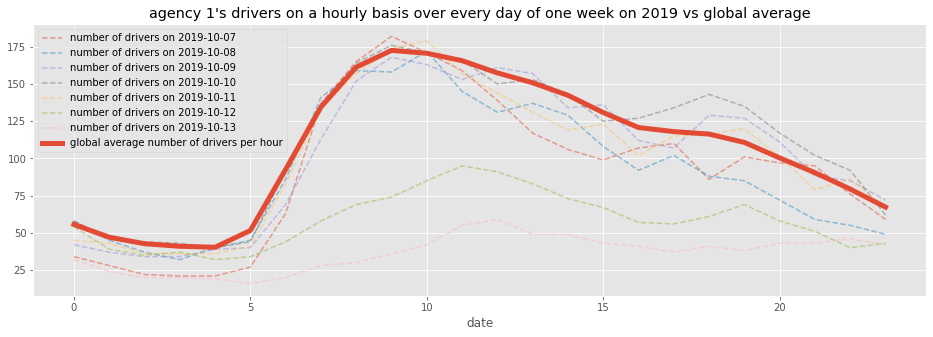

In [7]:
for i in range(7):
    _from = '2019-10-{:02d}'.format(7+i)
    _to = '2019-10-{:02d}'.format(8+i)
    condition = (df_dh.index >= _from) & (df_dh.index < _to)
    ax = df_dh[condition].reset_index().drivers.plot(
            alpha = 0.5, ls = '--',
            figsize=(16,5),
            label='number of drivers on {}'.format(_from))

plt.title("agency 1's drivers on a hourly basis over every day of one week on 2019 vs global average");
df_dh.groupby(df_dh.index.hour).drivers.mean().plot(ax=ax, lw=5, label='global average number of drivers per hour');
plt.legend();

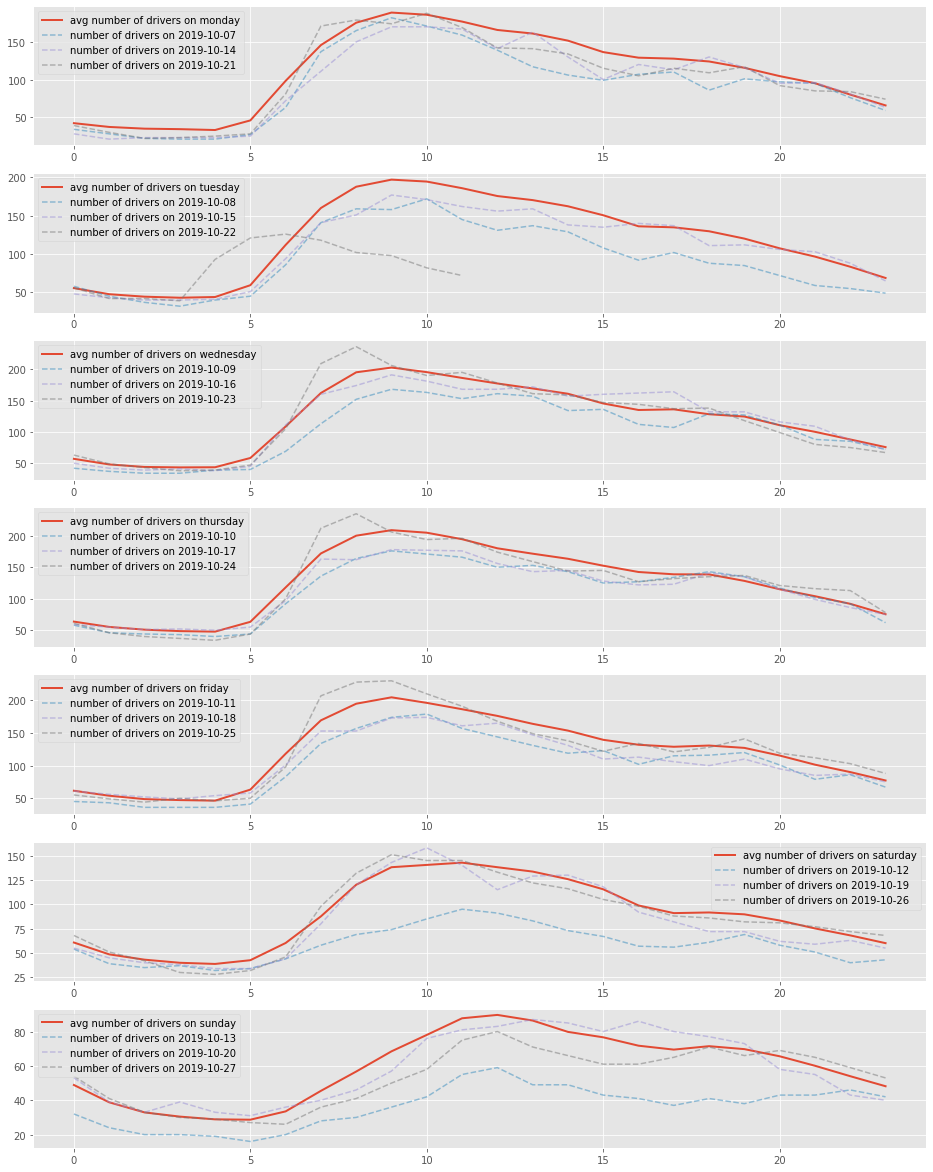

In [8]:

fig, axes = plt.subplots(7, 1, figsize=(16,21))
axes = axes.flatten()
for i in range(7):
    condition = df_dh.index.dayofweek == i
    df_dh[condition].groupby(df_dh[condition].index.hour).drivers.mean().reset_index().drivers.plot(
            ax=axes[i], lw=2,
            label='avg number of drivers on {}'.format(dow[i]))

    _from = '2019-10-{:02d}'.format(7+i)
    _to = '2019-10-{:02d}'.format(8+i)
    condition = (df_dh.index >= _from) & (df_dh.index < _to)
    df_dh[condition].reset_index().drivers.plot(
            ax = axes[i],
            alpha = 0.5, ls = '--',
            label='number of drivers on {}'.format(_from))
    
    _from = '2019-10-{:02d}'.format(14+i)
    _to = '2019-10-{:02d}'.format(15+i)
    condition = (df_dh.index >= _from) & (df_dh.index < _to)
    df_dh[condition].reset_index().drivers.plot(
            ax = axes[i],
            alpha = 0.5, ls = '--',
            label='number of drivers on {}'.format(_from))
    
    _from = '2019-10-{:02d}'.format(21+i)
    _to = '2019-10-{:02d}'.format(22+i)
    condition = (df_dh.index >= _from) & (df_dh.index < _to)
    df_dh[condition].reset_index().drivers.plot(
            ax = axes[i],
            alpha = 0.5, ls = '--',
            label='number of drivers on {}'.format(_from))

    axes[i].legend();

plt.legend();

In [9]:
df_Xy = pd.DataFrame(df_dh['drivers'])
df_Xy['hour'] = df_Xy.index.hour
df_Xy.shape

(4187, 2)

In [10]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120*24]
test = df_Xy[120*24:]
dates = df_Xy.index.tolist()
dates_train = dates[:120*24]
dates_test = dates[120*24:]

In [11]:
avg_per_dow_and_hour = []
for i in range(7):
    condition = train.index.dayofweek == i
    avg_per_dow_and_hour.append(
        train[condition].groupby(train[condition].index.hour).drivers.mean().reset_index(drop=True))

avg_per_dow_and_hour[0][7]

148.76470588235293

In [12]:
df_Xy['historical_avg'] = 0
for day in range(7):
    for hour in range(24):
        df_Xy.loc[(df_Xy.index.dayofweek == day)
                & (df_Xy.index.hour == hour), 'historical_avg'] = avg_per_dow_and_hour[day][hour]

In [13]:
df_Xy.columns

Index(['drivers', 'hour', 'historical_avg'], dtype='object')

In [14]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120*24]
test = df_Xy[120*24:]
dates = df_Xy.index.tolist()
dates_train = dates[:120*24]
dates_test = dates[120*24:]

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [227]:
look_back = 24*7*2
ds = train['drivers'].reset_index(drop=True).astype('float32').values
ds = ds.reshape(len(ds), -1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

X_train, y_train = create_dataset(ds, look_back)

ds = test['drivers'].reset_index(drop=True).astype('float32').values
ds = ds.reshape(len(ds), -1)
ds = scaler.fit_transform(ds)

X_test, y_test = create_dataset(ds, look_back)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2543, 336), (2543,), (970, 336), (970,))

In [228]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [229]:
# create and fit the LSTM network

# input 12 = 11.25 RMSE
# input 10 = 11.80 RMSE
# input 9 = 11.19 RMSE
# input 8 = 10.98 RMSE

model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
h = model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=0)

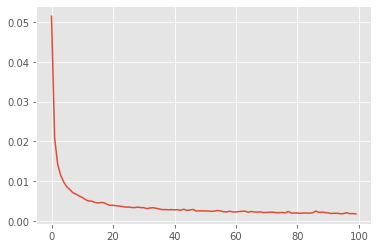

In [230]:
plt.plot(h.history['loss']);

In [231]:
# make predictions
train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))

# invert predictions
y_train_r = scaler.inverse_transform([y_train])
y_test_r = scaler.inverse_transform([y_test])


In [232]:
hist = []
predictions = []
last = np.array([X_test[0]])
for i in range(len(X_test)):
    pred = model.predict(last)
    predictions.append(scaler.inverse_transform(pred).flatten())
    #print('pred', pred.shape, pred)
    hist.append(last)
    last = last.flatten()
    last = np.hstack([last[1:], pred.flatten()]).reshape(1,1,-1)

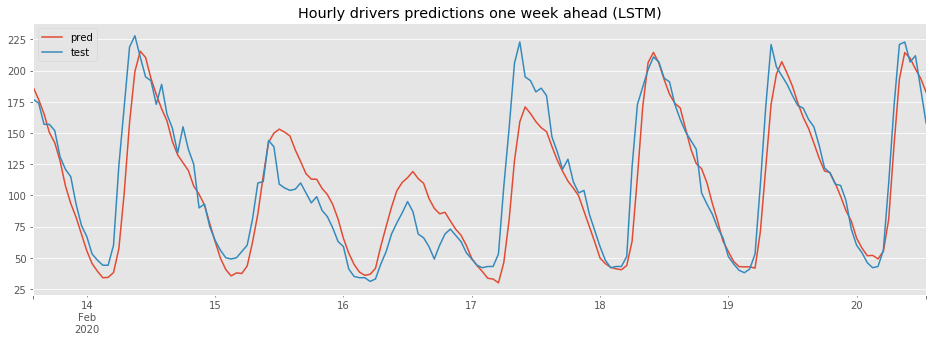

In [233]:
SAMPLES = 24*7
offset = 0
df = pd.DataFrame({'pred': np.array(predictions[offset:offset+SAMPLES]).flatten(),
               'test': test['drivers'].values[look_back+1+offset:look_back+1+offset+SAMPLES]},
               index = dates_test[look_back+1+offset:look_back+1+offset+SAMPLES])
df.plot(figsize=(16,5))
plt.title('Hourly drivers predictions one week ahead (LSTM)');

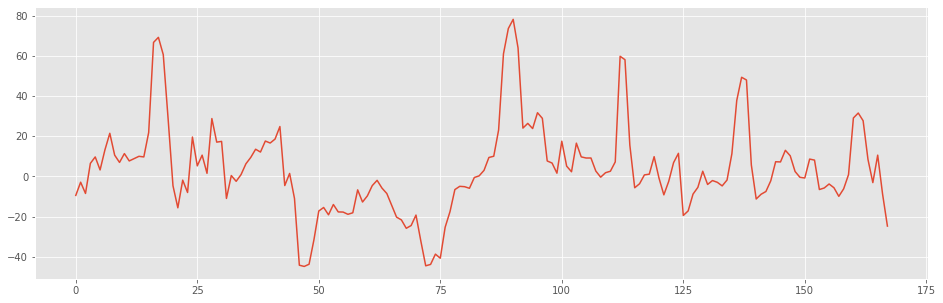

In [234]:
res = test['drivers'].values[look_back+1:look_back+1+SAMPLES].flatten() - np.array(predictions[:SAMPLES]).flatten()
plt.figure(figsize=(16,5))
plt.plot(res);

In [235]:

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train_r[0], train_pred[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_r[0], test_pred[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 9.23 RMSE
Test Score: 11.22 RMSE


In [236]:
train.drivers.values[look_back+1:].shape, train_pred.flatten().shape

((2543,), (2543,))

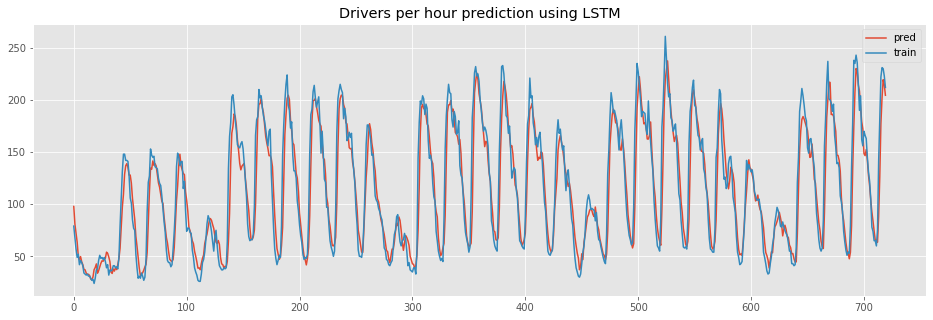

In [237]:
SAMPLES = 24*30
plt.figure(figsize=(16,5))
plt.plot(train_pred.flatten()[-SAMPLES:], label='pred')
plt.plot(train.drivers.values.flatten()[-SAMPLES:], label='train')
plt.title('Drivers per hour prediction using LSTM')
plt.legend();

In [238]:
res = train.drivers.values[look_back+1:].flatten() - train_pred.flatten()

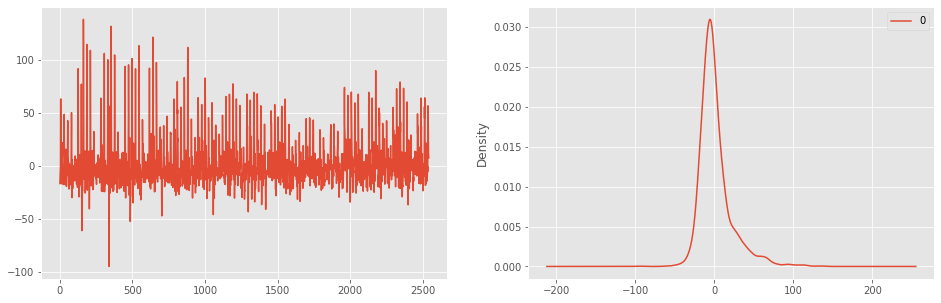

In [239]:
plt.figure(figsize=(16,5))
ax = plt.subplot('121')
ax.plot(res)
ax = plt.subplot('122')
pd.DataFrame(res).plot(kind='kde', ax=ax)
plt.show()

In [240]:
import statsmodels
from statsmodels.stats import stattools

print('Durbin Watson Statistic: {:0.4f}'.format(
        stattools.durbin_watson(res)))

Durbin Watson Statistic: 0.6165


Possitive correlation of the residuals. Let's make it visible

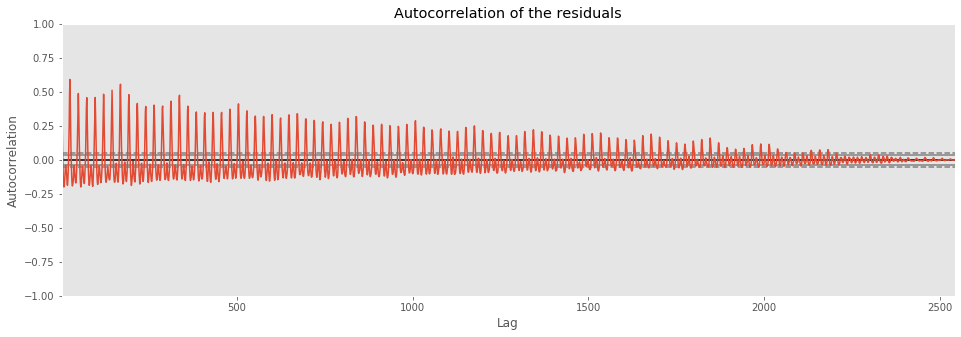

In [241]:
plt.figure(figsize=(16,5))
autocorrelation_plot(res);
plt.title('Autocorrelation of the residuals');

In [242]:
res.std(), sum(res > res.std()) / len(res)

(21.01240031283522, 0.1313409359024774)

Just in 12% of predictions the model exceeds the 24 drivers of error.

In [243]:
pd.DataFrame(res).describe()

,0
count,2543.000000
mean,1.332962
std,21.016533
min,-95.168488
25%,-10.832409
50%,-3.282501
75%,7.189260
max,138.191658


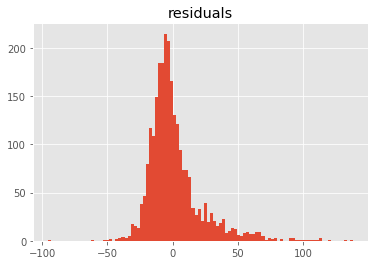

In [244]:
plt.hist(res, bins=100)
plt.title('residuals');

In [245]:
len(dates_test)-look_back-1, test_pred.shape

(970, (970, 1))

In [246]:
SAMPLES = 24*21
idx = look_back + 1

if len(dates_test)-idx > SAMPLES: idx = -SAMPLES

df = pd.DataFrame({'pred': test_pred.flatten()[-SAMPLES:],
              'test':test.drivers.values.flatten()[-SAMPLES:]},
            index = dates_test[-SAMPLES:])

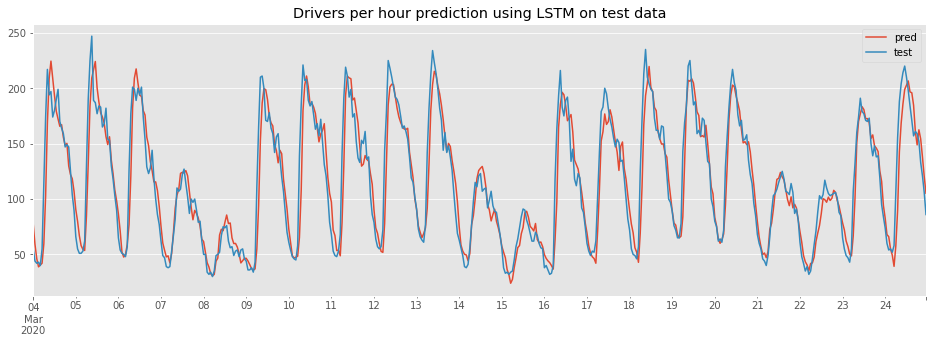

In [247]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
df.plot(ax=ax)
plt.title('Drivers per hour prediction using LSTM on test data')
plt.legend();

In [248]:
res = test.drivers.values[look_back+1:].flatten() - test_pred.flatten()

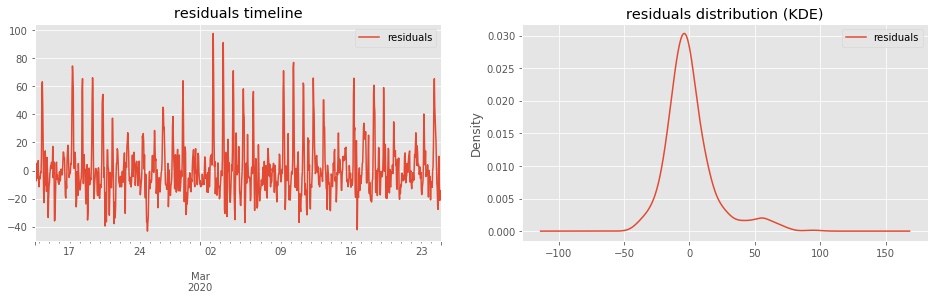

In [249]:
plt.figure(figsize=(16,4))
ax = plt.subplot('121')
df = pd.DataFrame({'residuals': res}, index = dates_test[look_back+1:])
df.plot(ax=ax)
ax.set_title('residuals timeline')
ax = plt.subplot('122')
pd.DataFrame({'residuals': res}).plot(kind='kde', ax=ax)
ax.set_title('residuals distribution (KDE)')
plt.show()

In [250]:
print('Durbin Watson Statistic: {:0.4f}'.format(
        stattools.durbin_watson(res)))

Durbin Watson Statistic: 0.5709


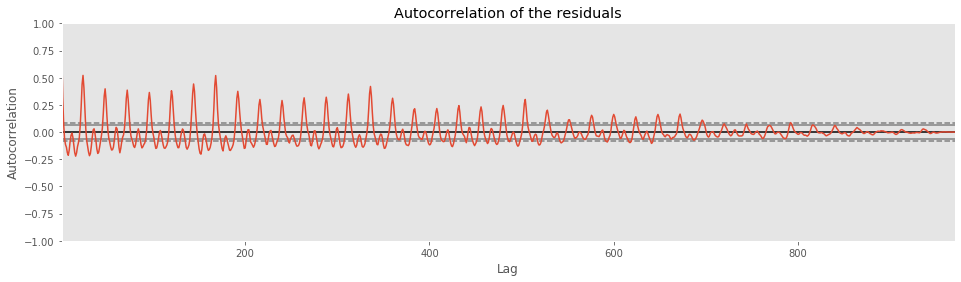

In [251]:
plt.figure(figsize=(16,4))
autocorrelation_plot(res);
plt.title('Autocorrelation of the residuals');

In [252]:
print('Standard Deviation: {:.02f}'.format(res.std()))
print('{:.02f}% of predictions were wrong for more than 1 stddev'.format(100 * sum(res > 1*res.std()) / len(res)))
print('{:.02f}% of predictions were wrong for more than 2 stddev'.format(100 * sum(res > 2*res.std()) / len(res)))
print('{:.02f}% of predictions were wrong for more than 3 stddev'.format(100 * sum(res > 3*res.std()) / len(res)))

Standard Deviation: 19.43
11.34% of predictions were wrong for more than 1 stddev
5.88% of predictions were wrong for more than 2 stddev
2.16% of predictions were wrong for more than 3 stddev


In [253]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8)                 11040     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 11,049
Trainable params: 11,049
Non-trainable params: 0
_________________________________________________________________


In [254]:
dates_test[0]

Timestamp('2020-01-30 13:00:00')

Day by Day predictions

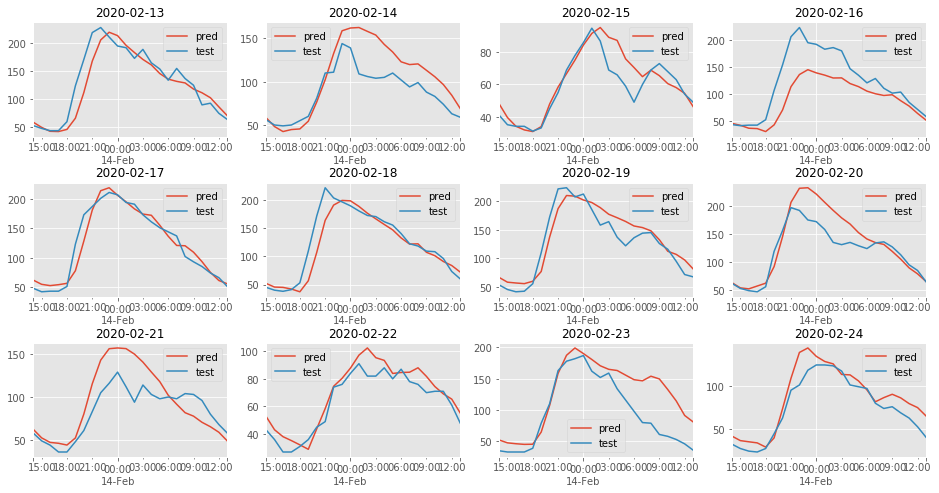

In [256]:
days = list(range(12))
fig, axes = plt.subplots(3, 4, figsize=(16,8))
axes = axes.flatten()
for day in days:
    hist = []
    predictions = []
    last = np.array([X_test[11+day*24]])
    for i in range(24):
        pred = model.predict(last)
        predictions.append(scaler.inverse_transform(pred).flatten())
        hist.append(last)
        last = last.flatten()
        last = np.hstack([last[1:], pred.flatten()]).reshape(1,1,-1)

    SAMPLES = 24
    offset = 0
    df = pd.DataFrame({'pred': np.array(predictions[offset:offset+SAMPLES]).flatten(),
                   'test': test['drivers'].values[day*24+look_back+1+11+offset:day*24+look_back+1+11+offset+SAMPLES]},
                   index = dates_test[look_back+1+offset:look_back+1+offset+SAMPLES])
    df.plot(ax=axes[day])
    axes[day].set_title('{}'.format(dates_test[look_back+1+offset+day*24].date()), fontsize=12);

plt.subplots_adjust(hspace=0.4)

LSTM works very good using just number of drivers in time. Let's see if we can work with more features

In [40]:
adsf lsdf break

SyntaxError: invalid syntax (<ipython-input-40-0aae20e9f5d6>, line 1)

In [ ]:
# We have 175 days, so we will use 120 to train the model
train = df_Xy[:120*24]
test = df_Xy[120*24:]
dates = df_Xy.index.tolist()
dates_train = dates[:120*24]
dates_test = dates[120*24:]

In [ ]:
look_back = 24*7
ds = train['drivers'].reset_index(drop=True).astype('float32').values
ds = ds.reshape(len(ds), -1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

X_train, y_train = create_dataset(ds, look_back)
# append features to train
X_train = np.hstack([X_train, train[look_back+1:]['historical_avg'].values.reshape(-1, 1)])
X_train = np.hstack([X_train, train[look_back+1:]['hour'].values.reshape(-1, 1)])

ds = test['drivers'].reset_index(drop=True).astype('float32').values
ds = ds.reshape(len(ds), -1)
ds = scaler.fit_transform(ds)

X_test, y_test = create_dataset(ds, look_back)
# append features to test
X_test = np.hstack([X_test, test[look_back+1:]['historical_avg'].values.reshape(-1, 1)])
X_test = np.hstack([X_test, test[look_back+1:]['hour'].values.reshape(-1, 1)])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back+2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
h = model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)

In [ ]:
plt.plot(h.history['loss']);

In [ ]:
# make predictions
train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))

# invert predictions
y_train_r = scaler.inverse_transform([y_train])
y_test_r = scaler.inverse_transform([y_test])

In [ ]:

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train_r[0], train_pred[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test_r[0], test_pred[:,0]))
print('Test Score: %.2f RMSE' % (test_score))